## The Importance of the Normal Distribution

The normal (or Gaussian) distribution is arguably the most important and widely used probability distribution in the field of statistics. First studied in the early 18th century by Abraham de Moivre, a French mathematician (though later explored further by Karl Friedrich Gauss, hence the name), the distribution is so prevalent in probability theory due to its unique statistical properties which lead to it featuring heavily in many natural contexts. 

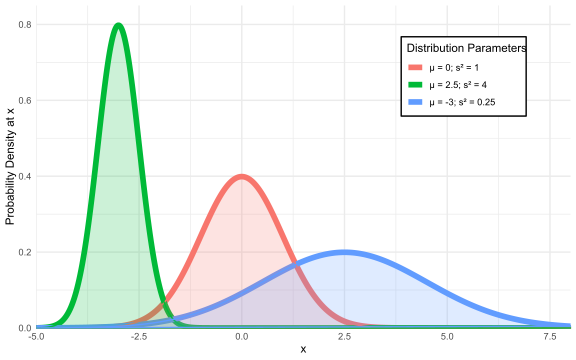

In [4]:
options(repr.plot.width=8, 
        repr.plot.height=5,
        jupyter.plot_mimetypes = "image/svg+xml")

library(ggplot2)
library(tidyr)
xrange <- seq(-5, 8, by = 0.01)
df <- data.frame(x = xrange,
                 dnorm(xrange),
                 dnorm(xrange, 2.5, 2),
                 dnorm(xrange, -3, 1/2))
df <- gather(df, "dist", "vals", 2:4)
ggplot(df, aes(x = x, y = vals, col = dist, fill = dist)) +
  geom_line(size = 2) +
  geom_polygon(alpha = 0.2, show.legend = FALSE) +
  labs(x = "x", y = "Probability Density at x", col = "Distribution Parameters ") +
  scale_color_discrete(labels = c("μ = 0; σ² = 1", "μ = 2.5; σ² = 4", "μ = -3; σ² = 0.25")) +
  theme_minimal() +
  theme(legend.position = c(0.8, 0.78)) +
  theme(legend.background = element_rect(fill = "white")) +
  coord_cartesian(expand = FALSE, ylim = c(0, 0.85))

One of the most important properties of the normal distribution is the central limit theorem. This states that if you take any sequence of independent, identically distributed random variables, calculate their partial sums and scale these so they are centred around zero and have unit variance, then the resulting random variable will have a distribution that is approximately normal. For example, if you were to flip a coin again and again until boredom forced you to stop, the resulting number of heads obtained (after appropriate scaling) would have an approximately normal distribution. Other examples of real life scenarios in which the normal distribution appears either approximately or exactly are:

* The distribution of heights and weights
* The time it takes to travel to work
* The volatility of stocks
* The position of a diffusing particle relative to its starting point

Since the normal distribution is so common in our statistical work and nature itself, it makes sense that we would want a method of generating our own normally distributed random variables. This is exactly what this series of blog posts is about.

## Generating Normal Random Variables

Anyone familiar with R may be wondering why this is a topic even worth discussing. After all, calling the built-in `rnorm()` function will give you as many normal random variables as you could possibly need with no effort required. And that is true; but how exactly does `rnorm()` give you these values? 

As smart as your computer may be, it turns out that it does not have a way to directly generate normal random variables. In fact, all it can do is generate standard uniform variables - that is picking a number randomly from the interval `(0,1)`. Even then, technically, this is not a random process, rather pseudo-random - the algorithms designed to do this, however, are good enough that we'll consider them random. It is then the job of cleverly designed statistical algorithms to take these standard uniform random variables and mutate them into the normal random variables that we require. This is exactly what `rnorm()` does, and by the end of this post you'll understand roughly how.

Before we begin generating random variables which follow the normal distribution, it is worth noting that really there is no such thing as *the* normal distribution. In fact there are infinitely many such distributions (as shown above). Each of these is categorised uniquely by their mean and variance. However, due to another useful property of the normal distribution, if we wish to generate any normal random variable, the only difficult part is first calculating a _standard_ normal random variable - that is, belonging to a normal distribution with mean zero and unit variance. Once we have this, we can use the property that if $Z$ is a normal random variable, then $X = \sigma Z + \mu$ is a normal random variable with mean $\mu$ and variance $\sigma^2$. 

## Inverse Transform Sampling

### A Theoretical Background

There are many different methods of generating normal random variables from a source of standard uniform variables many of which we will discuss in the following posts. The first of which and the subject of this post, is known as inverse transform sampling. The reason I have decided to start with this method, is that it is one of the simplest to introduce and its shortcomings lead on nicely to introducing alternative approaches.

Inverse transform sampling is a very versatile technique. Its use is not just limited to generating normal random variables but it can be used (in theory at least - we'll see more about this later) to generate a random variable with any given distribution. All we need to know is the cumulative distribution function (CDF) of the random variable we are trying to generate. This is the function given by $F_X(x) = \mathbb{P}(X\leq x)$. 

In order to utilise this CDF, along with our source of standard uniform random variables, to perform inverse transform sampling we first require its inverse. By definition of a CDF, we know that $F_X(x)$ is non-decreasing. Unfortunately, this alone cannot guarantee that $F_X(x)$ has a true inverse function; to be sure of this we require that $F_X(x)$ is strictly increasing. What we can do however is find a left-inverse, that is a function such that for any $u \in (0,1)$, $F_X\left(F_X^{-1}(u)\right) = u$. Specifically we can take $F_X^{-1}(u) = \textrm{inf}\{x : F_X(x) \geq u \}$. Although a true inverse is often easy to handle Mathematically, a left-inverse is sufficient for the requirements of inverse transform sampling. This fact is particularly important when the distribution we are trying to generate is discrete, in which case we are certain to not have a true inverse. 

We now make the following observation:

$$
\begin{align}
& \mathbb{P}(F_X^{-1}(U) \leq x) & \\ 
 &= \mathbb{P}(U \leq F_X(x)) & \textrm{[applying } F_X \textrm{ to both sides]} \\
 & = F_X(x) &  \textrm{[since } \mathbb{P}(U\leq y) = y \textrm{ when } U \textrm{ is a standard uniform r.v.]} 
\end{align}
$$

That is to say that $F_X^{-1}(U)$ and $X$ have the same distribution. Therefore, by taking our standard uniform samples and passing them through our inverse CDF, we can obtain new samples which will follow the target distribution that we were aiming to generate.

### The Intuition

If the last section seemed to go a bit too deep, don't worry – understanding the theoretical underpinnings of inverse transform sampling is not necessary for its algorithmic implementation. The main take away is that if we can find an inverse (or near-inverse) function for our target CDF $F_X$ which we will denote $F_X^{-1}$, we can then generate our standard uniform random variables, pop them into our inverse CDF, and as if by magic, the resulting values will follow the distribution we were aiming to generate.

There is one problem though. This is all dependent on *if* we can find an inverse CDF. Furthermore, what if we can't even find the CDF in the first place? It turns out that, although most of the distributions we care about have nice CDFs with computable inverses, the vast majority of random variables do not. When we do have a manageable CDF, we're all set; inverse transform sampling will work perfectly and if our inverse CDF is easy to compute, will be highly efficient. If we can't find such a CDF or its inverse, then we will have to consider other approaches.

### A Concrete Example

To demonstrate inverse transform sampling, we will apply it on a distribution which has a CDF suited to the method: the exponential distribution. The probability density function of an exponential random variable $X$ with rate parameter $\lambda$ is given by

$$
f_X(x)=
\begin{cases}
e^{-\lambda x} & x > 0\\
0 & \textrm{otherwise}
\end{cases}
$$

And so integrating gives a CDF of 

$$
F_X(x)=
\begin{cases}
1-e^{-\lambda x} & x > 0\\
0 & \textrm{otherwise}
\end{cases}
$$

We then set $u = F_X(x)$ and solve for $x$ to get $F_X^{-1}(u) = -\frac{1}{\lambda}\ln(1-u)$. From the result above, this tells us that the random variable $-\frac{1}{\lambda}\ln(1-U)$ has the same distribution as $X$. Furthermore, since $U$ and $1-U$ have the same distribution, we can generate $X$ by using $-\frac{1}{\lambda}\ln(U)$.

We can see this in practice here.

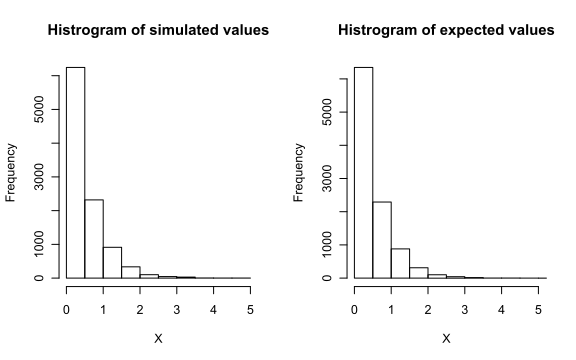

In [5]:
options(repr.plot.width=8, 
        repr.plot.height=5,
        jupyter.plot_mimetypes = "image/svg+xml")

lambda <- 2
U <- runif(10000)
X_simulated <- -1 / lambda * log(U)
X_expected <- rexp(10000, lambda)

par(mfrow = c(1, 2))
hist(X_simulated, xlab = "X",
     main = "Histrogram of simulated values",
     breaks = 10, xlim = c(0, 5))
hist(X_expected, xlab = "X",
     main = "Histrogram of expected values",
     breaks = 10, xlim = c(0, 5))

The exponential distribution isn't the only distribution that works well for inverse transform sampling. Here is a table of other distributions along with their PDFs, CDFs, and inverse CDFs, that can be effectively generated using inverse transform sampling.

### Application to the Normal Distribution

With a simple example of inverse transform sampling under our belt, we can now turn our attention to the normal distribution. As mentioned in the introduction, it will suffice to generate random variables with a standard normal distribution and then scale them appropriately to obtain the distribution we were targeting. The cumulative density function of the standard normal distribution is given by

$$
f_X(x)=\frac{1}{\sqrt{2\pi}} e^{\frac{-x^2}{2}}
$$

This leads us into a problem. It can be shown that the integral $\int e^{-x^2} dx$ has no closed form using the standard elementary functions. That means that we have no way of finding a simple expression for the normal CDF. The normal distribution is simply just one of those many troublesome distributions for which inverse transform sampling is difficult. Since we can't find a closed form the CDF we have very little chance of finding a nice way of expressing the inverse CDF that we need to implement the algorithm.

Thankfully though, we have a workaround. Although we are unable to find a closed form for the inverse CDF, it is not too hard to approximate it using numerical analysis. The exact details of the process are far beyond the scope of this post, revolving around Taylor series, convergence, and difference equations. All you need to know is that it is not too hard to approximate the inverse CDF we require using some carefully crafted polynomials. Using this trick, we can carry on just as if we have an explicit form for the CDf.

## Implementing the method

### The Algorithm

As mentioned in the previous section, we are forced to use an approximation for the inverse CDF of the normal distribution in order to implement this method. We could code this up ourselves but, luckily for us, R already has a built-in function which can do this for us. Specifically we will use the `qnorm()` function. This, given a vector of values between zero and one, will return for each element $u$, the value of the constant $x$ such that $\mathbb{P}(X\leq x) = u$. After a little thought, it should be clear that this is exactly the same process that our inverse CDF follows. Under the hood R uses the method we described above to generate these values - an approximation using carefully chosen polynomials. The raw source code for the `qnorm()` function can be found [here](https://github.com/SurajGupta/r-source/blob/master/src/nmath/qnorm.c) if you want to take a look at the internal workings.

Using this function to approximate our inverse CDF, the inverse transform sampling algorithm can be coded up in just a few lines.

In [6]:
inverseTransform <- function(n = 1) {
    # generate 'n' standard uniform samples
    u <- runif(n)
    # pass these samples through our inverse CDF
    x <- qnorm(u)
    # return the new, normally-distributed values
    return(x)
}

### Verification

We should now verify that the samples generated by this function are in fact normal. To do this we will begin by generating a thousand such samples.

In [7]:
# generate 1000 samples using our inverse transform sampling algorithm
samples <- inverseTransform(10^3)

The first check we will perform is to plot the histogram for these values. We also overlay the expected density curve for the standard normal distribution.

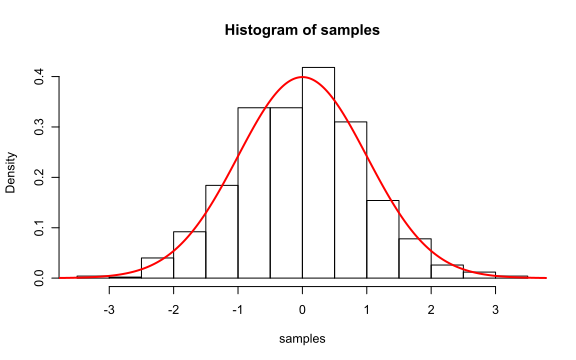

In [8]:
options(repr.plot.width=8, 
        repr.plot.height=5,
        jupyter.plot_mimetypes = "image/svg+xml")

# plot a histogram of our samples
hist(samples, freq = FALSE)
# add a standard normal density curve
densitySamps <- seq(-4, 4, by = 0.01)
lines(densitySamps, dnorm(densitySamps), lwd = 2, col = "red")

Looking good! Another visualisation we can use to verify normality is the normal [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). This compares the quantiles of our sample to the expected quantiles of a normal distribution. The closer to the diagonal line the points lie, the more likely it is that our samples are normally distributed.

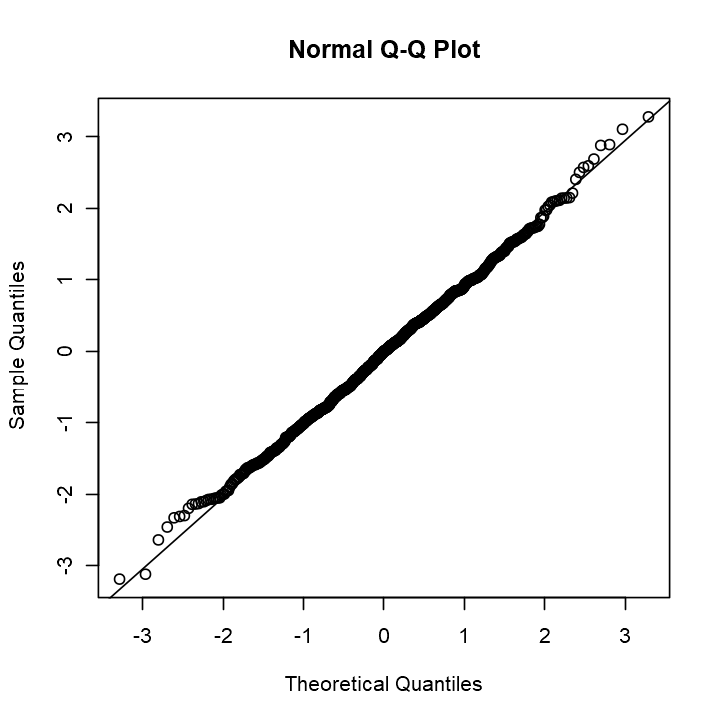

In [9]:
options(repr.plot.width=6, 
        repr.plot.height=6,
        jupyter.plot_mimetypes = "image/png")

qqnorm(samples)
qqline(samples)

That is a pretty much perfect Q-Q plot. There is some deviation from the diagonal at the tails of the distribution but that is to be expected since there are far fewer samples generated in those regions.

Lastly we can apply the [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test). This is a hypothesis test which evaluates how likely it is that a collection of samples were drawn from a normal distribution.

In [10]:
shapiro.test(samples)


	Shapiro-Wilk normality test

data:  samples
W = 0.99854, p-value = 0.5789


The test statistic generated ranges from zero to one, a higher value indicating that the samples are more likely to be from a normal distribution. Here we obtained a value of greater than 0.99 which should fill us with confidence. If we so desired we could also use the [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) - a hypothesis test similar to Shapiro-Wilk but that is non-parametric and generalises to comparing any two distributions - but by this point we already have a substantial amount of evidence that our generated samples are normally distributed. Success! 

### Benchmarking

Now that we know that our algorithm works as expected, we should also test its performance. We will do this by generating a large number of samples repeatedly and timing how long this takes. We will do this using the `rbenchmark` package. I have already written a [blog post](https://www.ttested.com/blog/2018/09/22/removing-zero-variance-columns/) about this package detailing why I find it to be the best benchmarking package available in R, so I will not go into much depth on how it should be used. We will test our function by generating one million samples and repeating this one hundred times for a total of one hundred million samples.

In [11]:
library(rbenchmark)
bm <- benchmark("Inverse Transform" = inverseTransform(10^6),
          columns = c("test", "replications", "elapsed"), 
          replications = 100)
bm

test,replications,elapsed
<fct>,<int>,<dbl>
Inverse Transform,100,5.51


As you can see in the table above, the one hundred million samples were generated in just a few seconds, showing incredible efficiency. 

## Next Steps: The Box-Muller Transform

Inverse transform sampling is an incredibly powerful tool. Even when dealing with troublesome distributions such as the normal distribution, by using appropriate approximations, we can still produce a working algorithm that generates samples with incredible speed. This method is so effective that, although implemented slightly differently, it is the exact procedure used by `rnorm()` to generate normally distributed samples in R. 

Really, we could end this series of posts here; we have already derived one of the most effective methods for generating normal random variables. But it feels like a bit of a hollow victory. For a start, the algorithm we produced isn't really _ours_ - it is heavily dependant on the `qnorm()` function. And even if we were to code up our own function to approximate the inverse normal CDF, it will always be just that, an approximation. 

There are many other methods of generating normal random variables. Many of these are exact methods, using no approximations. Others are capable of generating multi-dimensional normal random variables. Furthemore, a rare few can even perform better than the inverse transform sampling method that R uses. More importantly, by learning how these alternative methods work, we can discover new statistical concepts and see how they can be applied to solve real-world problems such as this. 

The next method we will look at is the Box-Muller transform, a method for generating two-dimensional standard normal random variables using an ingenious pair of transformations. We will learn how this method works and how to implement it in R in the next blog post. But for now, the approximate method that inverse transform sampling offers us will have to do. 